In [68]:
import pickle
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from uszipcode import SearchEngine
from sklearn.tree import DecisionTreeClassifier
import holidays


import sys
import os

# Add the grandparent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from Utils import helper_fn as helper



In [3]:
sns.set_theme(
    style="ticks",   # or 'darkgrid', 'ticks', 'white', 'dark'
    font_scale=1.5,      # ⬅ Boost font size globally
    rc={"axes.labelsize": 16, "axes.titlesize": 20}
)

## Loading Data Sets and Stuff
This requires running *'../../Create_Tune_Models.automatic_baseline.ipynb'* first.

In [4]:
# 2. Load the data
train_df_25 = pd.read_csv('../../Data/original/train_2025.csv') 

train_df_23 = pd.read_csv(r"C:/Users/yangs/Desktop/train_2023.csv")

train_df = pd.concat([train_df_23, train_df_25], ignore_index=True)

test_df = pd.read_csv('../../Data/original/test_2025.csv')



In [8]:
# mode_value_marry = train_df['marital_status'].mode().iloc[0]
# train_df['marital_status'] = train_df['marital_status'].fillna(mode_value_marry).astype('int64')

# mean_value_payout = train_df['claim_est_payout'].mean()
# train_df['claim_est_payout'] = train_df['claim_est_payout'].fillna(mean_value_payout)

# mode_value_vage = train_df['age_of_vehicle'].mode().iloc[0]
# train_df['age_of_vehicle'] = train_df['age_of_vehicle'].fillna(mode_value_vage).astype('int64')


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37000 entries, 0 to 36999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             37000 non-null  int64  
 1   age_of_driver            37000 non-null  int64  
 2   gender                   37000 non-null  object 
 3   marital_status           37000 non-null  int64  
 4   safty_rating             37000 non-null  int64  
 5   annual_income            37000 non-null  int64  
 6   high_education_ind       37000 non-null  int64  
 7   address_change_ind       37000 non-null  int64  
 8   living_status            37000 non-null  object 
 9   zip_code                 37000 non-null  int64  
 10  claim_date               37000 non-null  object 
 11  claim_day_of_week        37000 non-null  object 
 12  accident_site            37000 non-null  object 
 13  past_num_of_claims       37000 non-null  int64  
 14  witness_present_ind   

In [67]:
def impute_missing_values(df, ignore_columns=None):
    """
    Imputes missing values:
    - For float or numeric columns, fills with mean.
    - For categorical or other columns, fills with mode.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        ignore_columns (list or None): List of columns to skip. Default is None.
    
    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """
    df = df.copy()
    if ignore_columns is None:
        ignore_columns = []
        
    for col in df.columns:
        if col in ignore_columns:
            continue
        if df[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df[col]):
                mean_val = df[col].mean()
                df[col] = df[col].fillna(mean_val)
            else:
                mode_val = df[col].mode().iloc[0]
                df[col] = df[col].fillna(mode_val)
    return df


def cleaning(df):
    colnames_to_int = ['marital_status', 'high_education_ind', 'address_change_ind',  'policy_report_filed_ind']
    df[colnames_to_int] = df[colnames_to_int].astype(int)
    colnames_to_str = ['witness_present_ind','zip_code']
    df[colnames_to_str] = df[colnames_to_str].astype(str)
    
    df['claim_date']=pd.to_datetime(df['claim_date'])
    df['zip_code'] = df['zip_code'].str.zfill(5)
    
    return(df)

def age_cap(df, age_cap, age_col='age_of_driver'):
    df.loc[df[age_col] > age_cap, age_col] = age_cap
    return df

def assign_age_group(df, age_col='age_of_driver', new_col='age_group'):
    """
    Adds a categorical age group column to the dataframe based on age_of_driver.
    Groups:
        - '18-19'
        - '20-38'
        - '39-49'
        - '50-81'
        - '82-'
    """
    bins = [17, 19, 38, 49, 81, float('inf')]
    labels = ['A', 'B', 'C', 'D', 'E']
    df[new_col] = pd.cut(df[age_col], bins=bins, labels=labels, right=True)
    return df


def extract_datetime_features(df, date_col='claim_date', include_holidays=True):
    """
    Extracts basic datetime features from a given datetime column.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        date_col (str): The name of the datetime column.

    Returns:
        pd.DataFrame: DataFrame with new datetime-derived columns.
    """
    df = df.copy()
    
    # Ensure column is datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Extract common date features
    df[f'{date_col}.year'] = df[date_col].dt.year
    df[f'{date_col}.month'] = df[date_col].dt.month
    df[f'{date_col}.day'] = df[date_col].dt.day
    df[f'{date_col}.dayofweek'] = df[date_col].dt.dayofweek
    df[f'{date_col}.weekofyear'] = df[date_col].dt.isocalendar().week.astype('Int64')
    
    # Additional datetime features
    df[f'{date_col}.quarter'] = df[date_col].dt.quarter
    df[f'{date_col}.is_weekend'] = df[date_col].dt.dayofweek >= 5

    if include_holidays:
        us_holidays = holidays.US()
        df[f'{date_col}.is_holiday'] = df[date_col].isin(us_holidays)
    
    df = df.drop(columns = ['claim_date', 'claim_day_of_week'])

    return df



def process_zipcode_features(df, zip_col='zip_code', plot=False):
    """
    Looks up and processes ZIP code-level features for a given DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a ZIP code column.
        zip_col (str): Name of the ZIP code column in the DataFrame.
        plot (bool): If True, plots histogram of log population.

    Returns:
        pd.DataFrame: Processed ZIP code DataFrame with selected features.
    """
    search_zip = SearchEngine()
    unique_zip = df[zip_col].unique()

    zip_code_basic_features = ['zipcode', 'zipcode_type', 'state', 'population']
    zip_code_lite = []

    for zip_code in unique_zip:
        zip_info = search_zip.by_zipcode(zip_code)
        if zip_info is not None:
            zip_dict = zip_info.to_dict()
            zip_dict_lite = {key: zip_dict.get(key, np.nan) for key in zip_code_basic_features}
            zip_code_lite.append(zip_dict_lite)

    # Handle ZIP code 0 case explicitly
    zero_dict_lite = {key: np.nan for key in zip_code_basic_features}
    zero_dict_lite['zipcode'] = '00000'
    zero_dict_lite['zipcode_type'] = 'UNIQUE'
    zip_code_lite.append(zero_dict_lite)

    zip_code_df = pd.DataFrame(zip_code_lite)
    zip_code_df['zipcode'] = zip_code_df['zipcode'].astype(str).str.zfill(5)

    # Compute log population
    zip_code_df['log_population'] = np.log1p(zip_code_df['population'])

    # Bin log population
    zip_code_df['log_pop_bin'] = 0
    bins = [0, 5, 10, np.inf]
    labels = [1, 2, 3]
    non_null_mask = zip_code_df['log_population'].notnull()

    zip_code_df.loc[non_null_mask, 'log_pop_bin'] = pd.cut(
        zip_code_df.loc[non_null_mask, 'log_population'],
        bins=bins,
        labels=labels,
        right=False
    ).astype(int)

    # Optional histogram
    if plot:
        sns.histplot(zip_code_df['log_population'], bins=15)
        
    zip_features = zip_code_df.drop(columns=['population', 'log_population'])
    
    df = df.merge(zip_features, left_on='zip_code', right_on='zipcode', how='left')
    df = df.drop(columns= ['zip_code', 'zipcode'])
    # Clean up
    return df

def price_categories(df, col = 'vehicle_price', new_col_name = 'vehicle_price_categories'):
    df = df.copy()
    df[new_col_name] = ['under_15k' if x<=15000  else 
                        'btw_20_30k' if 20000<=x<30000 else
                        'btw_30_40k' if 30000<=x<40000 else
                        'btw_40_50k' if 40000<=x<50000 else
                        'above_50k' for x in df[col]]
    return(df)

def liab_prct_group(df, col = 'liab_prct', new_col_name = 'liab_prct_group'):
    bins = [0, 5, 47.5, 52.5, 95, np.inf]
    labels = [0, 1, 2, 3, 4]

    df[new_col_name] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    return(df)

def zero_payout(df, col = 'claim_est_payout', new_col_name = 'zero_payout'):
    df[new_col_name] = [1 if x > 0 else 0 for x in df[col]]
    return(df)


def add_interaction_features(df):
    """
    Adds meaningful interaction features based on financial and vehicle attributes.
    
    Parameters:
        df (pd.DataFrame): Input dataframe with necessary columns.
        
    Returns:
        pd.DataFrame: DataFrame with additional interaction features.
    """
    df = df.copy()
    
    # Avoid division by zero or NaN propagation
    epsilon = 1e-5  # Small value to prevent divide-by-zero errors

    # Claim to income ratio
    df['claim_to_income_ratio'] = df['claim_est_payout'] / (df['annual_income'] + epsilon)

    # Vehicle price to income
    df['vehicle_price_to_income'] = df['vehicle_price'] / (df['annual_income'] + epsilon)
    
    # Income to age
    df['income_to_age'] = df['annual_income'] / (df['age_of_driver'] + epsilon)

    # Claim amount per age
    df['claim_amt_per_age'] = df['claim_est_payout'] / (df['age_of_driver'] + epsilon)
    
    # Claim number per age
    df['claim_nmb_per_age'] = df['past_num_of_claims'] / (df['age_of_driver'] + epsilon)
    
    # Claim number per vage
    df['claim_num_per_adr'] = df['past_num_of_claims'] / (df['age_of_vehicle'] + epsilon)

    # Age to vehicle price ratio
    df['price_to_age_ratio'] =  (df['vehicle_price'] )/ (df['age_of_driver']+ epsilon)

    # Vehicle price per weight
    df['price_per_weight'] = df['vehicle_price'] / (df['vehicle_weight'] + epsilon)

    # Liability-weighted claim
    df['liab_weighted_claim'] = df['liab_prct'] * df['claim_est_payout']

    # Marital × Income (if marital status is encoded)
    df['married_income'] = df['marital_status'].astype(int) * df['annual_income']

    return df


In [21]:
train_df_25 = cleaning(impute_missing_values(train_df_25, 'witness_present_ind'))
train_df_23 = cleaning(impute_missing_values(train_df_23, 'witness_present_ind'))

train_df = cleaning(train_df)
test_df = cleaning(impute_missing_values(test_df, ['witness_present_ind', 'fraud']))

In [28]:
temp_df = train_df.copy()

# Feature 1 -- Age Categories:
1. 18-19
2. 20-38
3. 39-49
4. 50-81
5. 82-

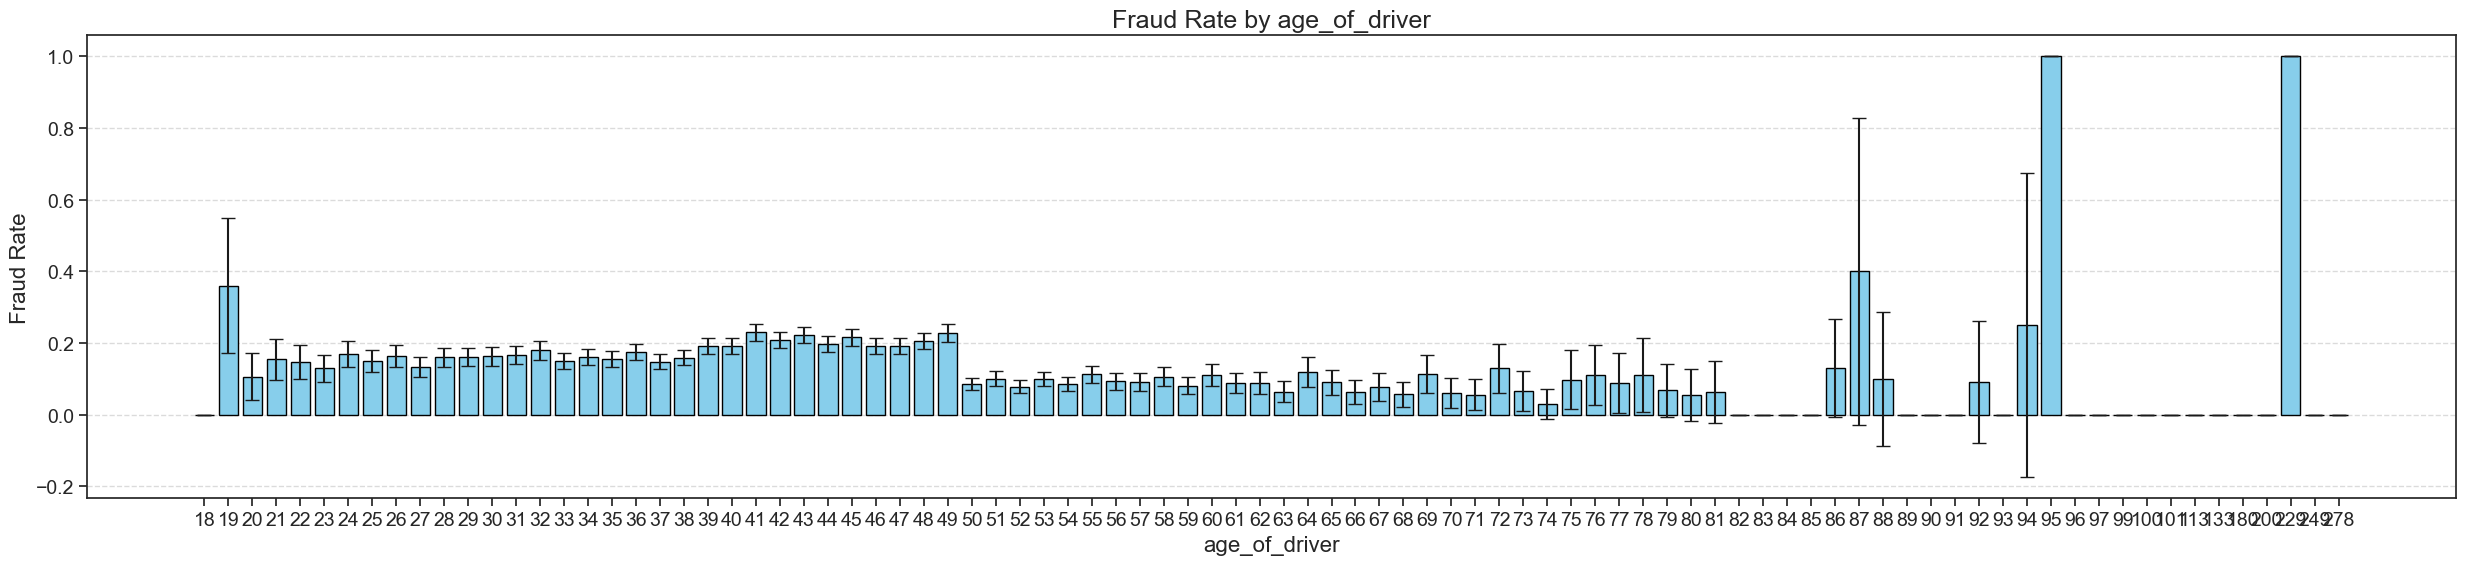

In [29]:
helper.plot_fraud_rate_by_category(temp_df, 'age_of_driver', figsize=(25, 6))

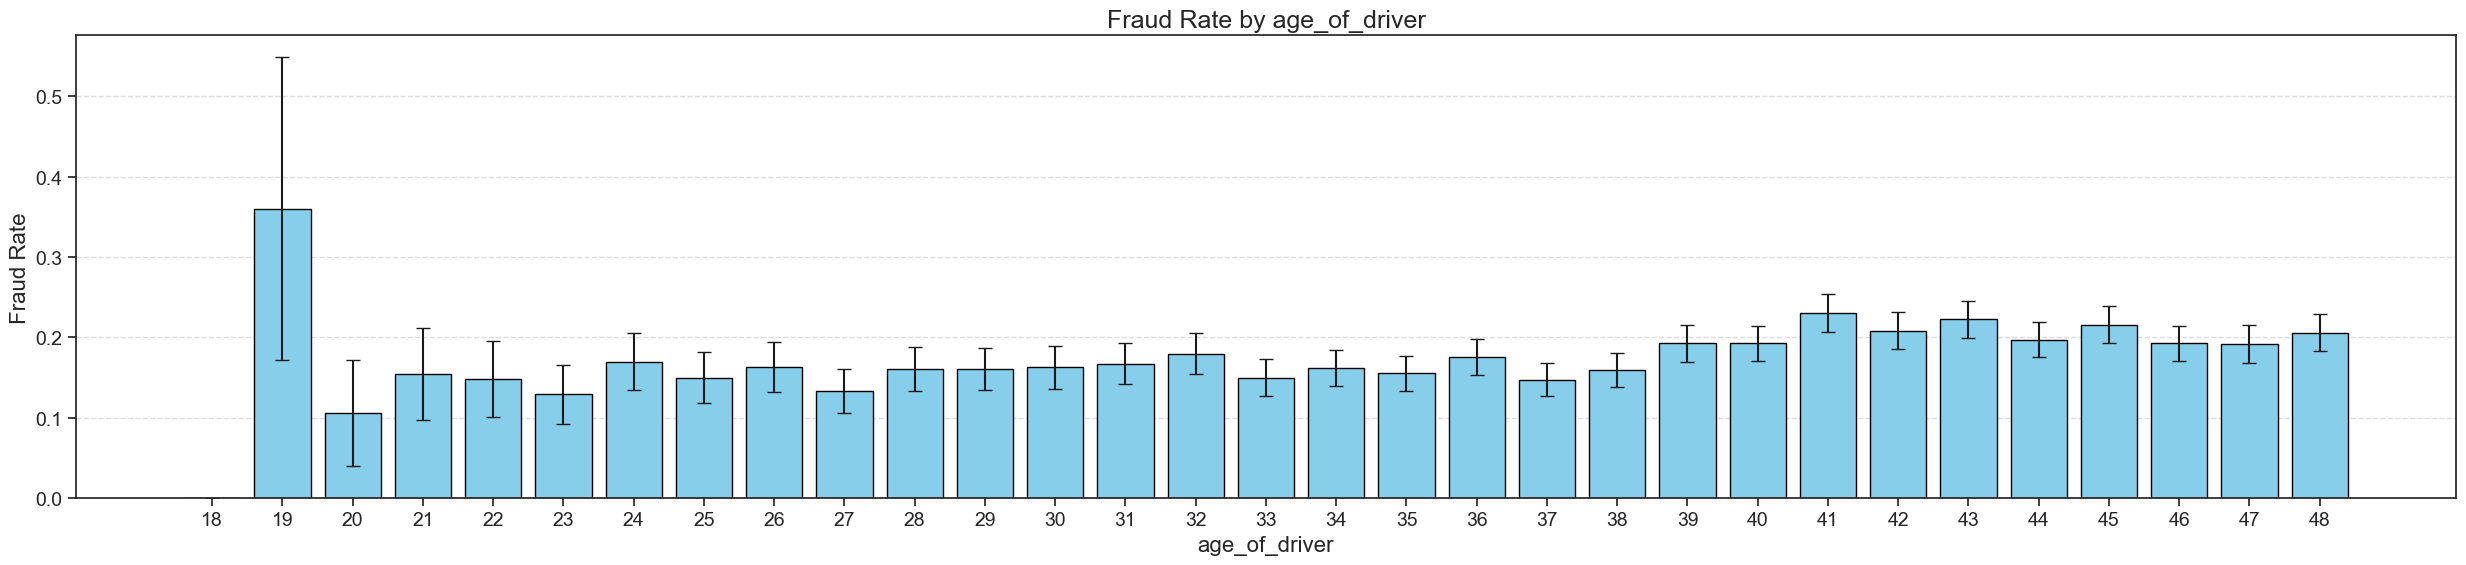

In [30]:
helper.plot_fraud_rate_by_category(temp_df[temp_df['age_of_driver'] < 49], 'age_of_driver', figsize=(25, 6))

c:\Users\yangs\Documents\Python Projects\NESS-2025\Utils\helper_fn.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rates = df.groupby(category_col)[target_col].mean().sort_index()


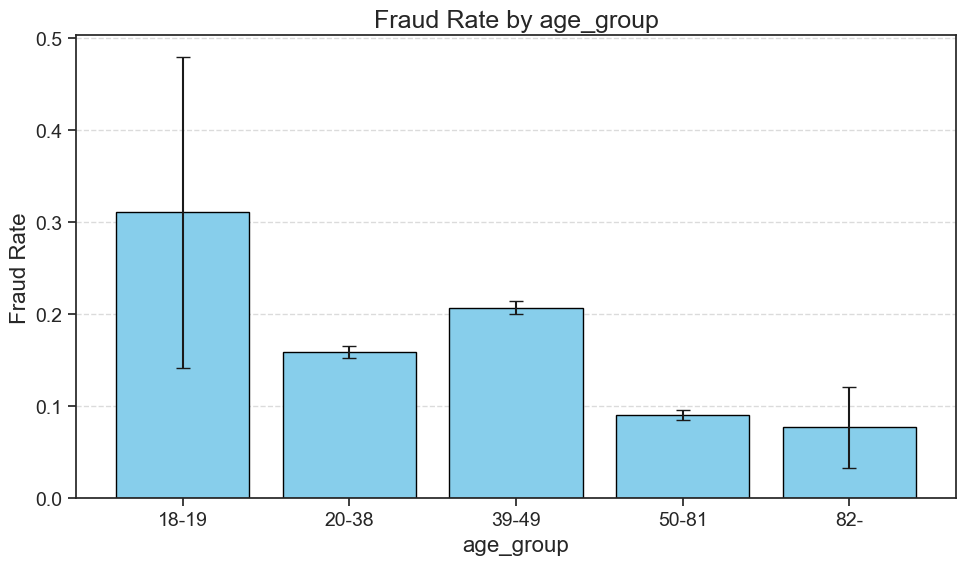

In [31]:
# Define bin edges and labels
bins = [18, 20, 38.5, 49.5, 82, float('inf')]
labels = ['18-19', '20-38', '39-49', '50-81', '82-']
# labels = ['young', 'middle_age', 'elderly']

# Create new categorical variable
temp_df['age_group'] = pd.cut(
    temp_df['age_of_driver'],
    bins=bins,
    labels=labels,
    right=False  # include left endpoint, exclude right
)

helper.plot_fraud_rate_by_category(temp_df, 'age_group')

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37000 entries, 0 to 36999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   claim_number             37000 non-null  int64         
 1   age_of_driver            37000 non-null  int64         
 2   gender                   37000 non-null  object        
 3   marital_status           37000 non-null  int32         
 4   safty_rating             37000 non-null  int64         
 5   annual_income            37000 non-null  int64         
 6   high_education_ind       37000 non-null  int32         
 7   address_change_ind       37000 non-null  int32         
 8   living_status            37000 non-null  object        
 9   zip_code                 37000 non-null  object        
 10  claim_date               37000 non-null  datetime64[ns]
 11  claim_day_of_week        37000 non-null  object        
 12  accident_site            37000 n

In [51]:
temp_df = extract_datetime_features(train_df_25)
temp_df = process_zipcode_features(temp_df)
temp_df = price_categories(temp_df)
temp_df = zero_payout(temp_df)

In [52]:
'age_of_driver', 'marital_status', 'annual_income', 'liab_prct', 'claim_est_payout', 'vehicle_category', 'vehicle_price', 'vehicle_weight'

('age_of_driver',
 'marital_status',
 'annual_income',
 'liab_prct',
 'claim_est_payout',
 'vehicle_category',
 'vehicle_price',
 'vehicle_weight')

In [66]:
temp_df = add_interaction_features(temp_df)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   claim_number              18000 non-null  int64  
 1   age_of_driver             18000 non-null  int64  
 2   gender                    18000 non-null  object 
 3   marital_status            18000 non-null  int32  
 4   safty_rating              18000 non-null  int64  
 5   annual_income             18000 non-null  int64  
 6   high_education_ind        18000 non-null  int32  
 7   address_change_ind        18000 non-null  int32  
 8   living_status             18000 non-null  object 
 9   accident_site             18000 non-null  object 
 10  past_num_of_claims        18000 non-null  int64  
 11  witness_present_ind       18000 non-null  object 
 12  liab_prct                 18000 non-null  int64  
 13  channel                   18000 non-null  object 
 14  policy

In [60]:
temp_df

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,accident_site,...,zero_payout,claim_to_income_ratio,vehicle_price_to_income,claim_amt_per_age,claim_nmb_per_age,price_to_age_ratio,price_per_weight,liab_weighted_claim,married_income,claim_num_per_adr
0,2759,58,M,1,83,117115,1,0,Own,Local,...,0,0.000000,0.470195,0.000000,0.000000,949.428725,2.559447,0.00,117115,0
1,11338,37,F,0,76,57945,1,0,Rent,Parking Lot,...,0,0.000000,0.516655,0.000000,0.378378,809.123189,1.326405,0.00,0,0
2,23150,33,F,0,82,79027,1,0,Rent,Local,...,0,0.000000,0.189809,0.000000,0.000000,454.545317,1.401727,0.00,0,0
3,19040,43,F,0,40,98544,1,0,Own,Parking Lot,...,1,0.008632,0.942395,19.782088,0.000000,2159.705414,4.332523,85063.00,0,0
4,10803,43,F,1,84,62619,1,1,Own,Parking Lot,...,1,0.053911,1.182896,78.508121,0.209302,1722.598085,1.541995,195799.30,62619,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,29803,43,F,1,65,97505,1,0,Own,Local,...,0,0.000000,0.153838,0.000000,0.255814,348.837128,1.235672,0.00,97505,0
17996,5391,33,F,0,65,81642,1,1,Own,Local,...,1,0.009091,0.183729,22.491205,0.393939,454.545317,0.912247,17070.83,0,13
17997,861,39,M,0,84,123385,0,1,Own,Local,...,0,0.000000,0.482338,0.000000,0.410256,1525.982454,4.350289,0.00,0,16
17998,15796,49,F,0,89,91848,1,0,Rent,Local,...,1,0.005828,0.163313,10.924896,0.326531,306.122387,2.445946,12847.68,0,0


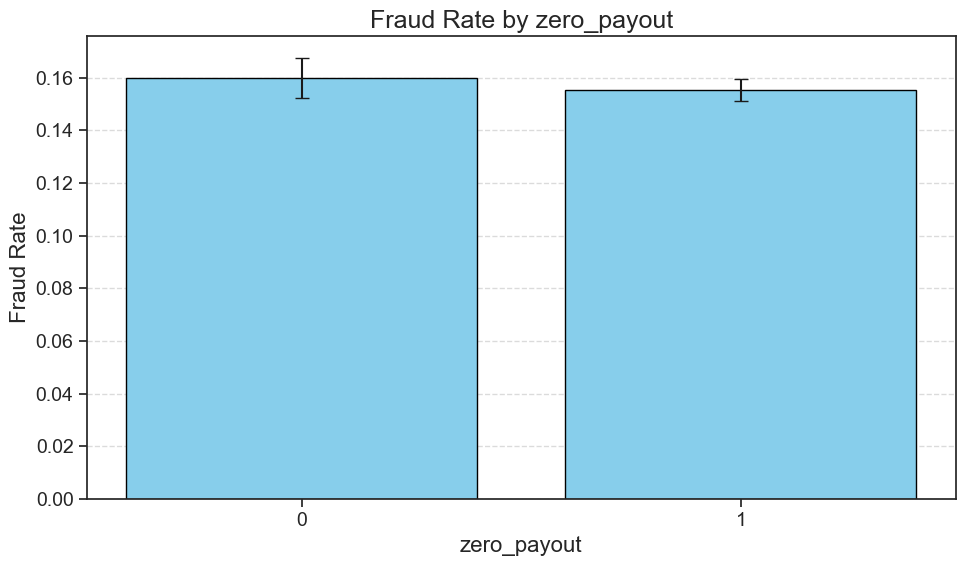

In [35]:
helper.plot_fraud_rate_by_category(zero_payout(temp_df), 'zero_payout')

c:\Users\yangs\Documents\Python Projects\NESS-2025\Utils\helper_fn.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rates = df.groupby(category_col)[target_col].mean().sort_index()


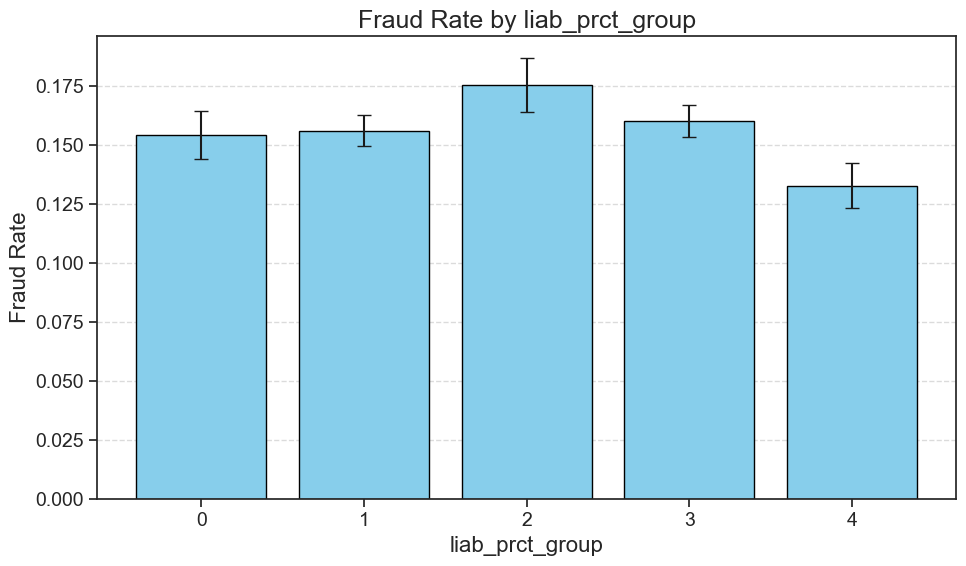

In [ ]:
helper.plot_fraud_rate_by_category(liab_prct_group(temp_df), 'liab_prct_group')